In [ ]:
!pip install pytorch-lightning

In [ ]:
%pip install --pre torch==2.0.1+cu118 torchvision==0.15.2+cu118 --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import torch, torchvision
torch.__version__, torchvision.__version__

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
# Install Albumentation library
%pip install albumentations

In [ ]:
# Install LR finder
%pip install torch-lr-finder

In [ ]:
# Install GradCam
%pip install grad-cam

In [53]:
# Import all the required modules
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import math
from collections import OrderedDict
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets


import albumentations as A
from albumentations.pytorch import ToTensorV2


from torch_lr_finder import LRFinder

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [62]:

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

In [ ]:
%pip install seaborn

In [ ]:
from visualize import display_cifar_data_samples

DISPLAY_SAMPLES = 20
sample, _ = train[4]
display_cifar_data_samples(train, DISPLAY_SAMPLES, classes)

In [16]:
from torchvision.datasets import CIFAR10

In [58]:
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
AVAIL_GPUS

1

In [59]:
from torch.utils.data import DataLoader, random_split
from pytorch_lightning import LightningModule, Trainer

In [67]:
from datasets import AlbumDataset
from augmentations import train_set_transforms, test_set_transforms

In [68]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18Model(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, block=BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10):
        super(ResNet18Model, self).__init__()
        self.data_dir = data_dir
        self.num_classes = num_classes

        # Get the dictionary with augmentations
        self.train_transforms = A.Compose(train_set_transforms.values())
        self.test_transforms = A.Compose(test_set_transforms.values())

        # means = [0.4914, 0.4822, 0.4465]
        # stds = [0.2470, 0.2435, 0.2616]

        # self.train_transforms = A.Compose(
        #     [
        #         A.Normalize(mean=means, std=stds, always_apply=True),
        #         A.PadIfNeeded(min_height=36, min_width=36, always_apply=True),
        #         A.RandomCrop(height=32, width=32, always_apply=True),
        #         A.HorizontalFlip(),
        #         A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, fill_value=means),
        #         ToTensorV2(),
        #     ]
        # )
        # self.test_transforms = A.Compose(
        #     [
        #         A.Normalize(mean=means, std=stds, always_apply=True),
        #         ToTensorV2(),
        #     ]
        # )

        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def validation_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = F.nll_loss(logits, y)
      preds = torch.argmax(logits, dim=1)
      self.accuracy(preds, y)

      # Calling self.log will surface up scalars for you in TensorBoard
      self.log("val_loss", loss, prog_bar=True)
      self.log("val_acc", self.accuracy, prog_bar=True)
      return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
      LEARNING_RATE = 0.03
      WEIGHT_DECAY = 1e-4
      return torch.optim.SGD(self.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

    def prepare_data(self):
        # download
        AlbumDataset(self.data_dir, train=True, download=True)
        AlbumDataset(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

      # Assign train/val datasets for use in dataloaders
      if stage == "fit" or stage is None:
          cifar_full = AlbumDataset(self.data_dir, train=True, transform=self.train_transforms)
          self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

      # Assign test dataset for use in dataloader(s)
      if stage == "test" or stage is None:
          self.cifar_test = AlbumDataset(self.data_dir, train=False, transform=self.test_transforms)

    def train_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=BATCH_SIZE, num_workers=os.cpu_count())


In [65]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]
train_transforms = A.Compose(
            [
                A.Normalize(mean=means, std=stds, always_apply=True),
                A.PadIfNeeded(min_height=36, min_width=36, always_apply=True),
                A.RandomCrop(height=32, width=32, always_apply=True),
                A.HorizontalFlip(),
                A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, fill_value=means),
                ToTensorV2(),
            ]
        )

In [70]:
# from resnet import ResNet18
# init the model
resnet_model = ResNet18Model()

# init Dataloader from MNIST Dataloader
train_ds = AlbumDataset(PATH_DATASETS, train=True, download=True, transform= train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

# initialize the trainer
trainer = Trainer(
    max_epochs = 3
)

# Train the model
trainer.fit(resnet_model, train_loader)

Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type        | Params
---------------------------------------
0 | conv1  | Conv2d      | 1.7 K 
1 | bn1    | BatchNorm2d | 128   
2 | layer1 | Sequential  | 147 K 
3 | layer2 | Sequential  | 525 K 
4 | layer3 | Sequential  | 2.1 M 
5 | layer4 | Sequential  | 8.4 M 
6 | linear | Linear      | 5.1 K 
---------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'ResNet18Model' object has no attribute 'accuracy'

In [ ]:
from datasets import AlbumDataset
from augmentations import train_set_transforms, test_set_transforms

# Get the dictionary with augmentations
train_transforms = A.Compose(train_set_transforms.values())
test_transforms = A.Compose(test_set_transforms.values())

# Create custom Dataset to support albumentations library
train_set = AlbumDataset('./data', train=True, download=True, transform=train_transforms)
test_set = AlbumDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


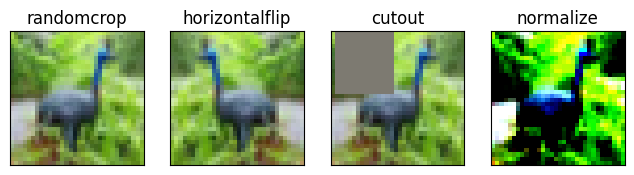

In [28]:
from visualize import visualize_cifar_augmentation

aug_train = AlbumDataset('./data', train=True, download=True)

aug_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=1),
    'horizontalflip': A.HorizontalFlip(p=1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=(0.49139968*255, 0.48215827*255, 0.44653124*255), mask_fill_value=None, p=1),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

visualize_cifar_augmentation(aug_train, aug_set_transforms)

In [ ]:
SEED = 8
BATCH_SIZE = 512

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


In [ ]:
from resnet import ResNet18
from utils import get_summary

get_summary(ResNet18(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
# Put the model on selected device
model = ResNet18().to(device)

# Optimization algorithm to update the weights
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

# Loss Function
criterion = nn.CrossEntropyLoss()

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.02E-02


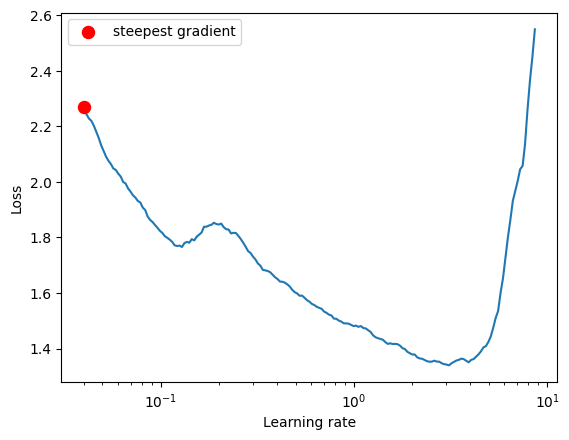

In [ ]:
# LR finder
from torch_lr_finder import LRFinder
lr_finder2 = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder2.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder2.plot()
lr_finder2.reset()

In [ ]:
EPOCHS = 20

MAX_LR = 6.79E-02    # Suggested LR
STEPS_PER_EPOCH = len(train_loader)

In [ ]:
from training_utils import train, test, get_lr

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=MAX_LR,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                epochs=EPOCHS,
                                                pct_start=int(0.3*EPOCHS)/EPOCHS if EPOCHS != 1 else 0.5,   # 30% of total number of Epochs
                                                div_factor=100,
                                                three_phase=False,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                )

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    learning_rates.append(get_lr(optimizer))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.3324 Batch_id=97 Accuracy=37.28: 100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


Test set: Average loss: 0.0029, Accuracy: 4936/10000 (49.36%)

Epoch 2


Train: Loss=0.9123 Batch_id=97 Accuracy=60.49: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]


Test set: Average loss: 0.0022, Accuracy: 6158/10000 (61.58%)

Epoch 3


Train: Loss=0.6993 Batch_id=97 Accuracy=70.52: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


Test set: Average loss: 0.0017, Accuracy: 7064/10000 (70.64%)

Epoch 4


Train: Loss=0.5680 Batch_id=97 Accuracy=76.93: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]


Test set: Average loss: 0.0025, Accuracy: 6436/10000 (64.36%)

Epoch 5


Train: Loss=0.5055 Batch_id=97 Accuracy=80.56: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0020, Accuracy: 6826/10000 (68.26%)

Epoch 6


Train: Loss=0.4906 Batch_id=97 Accuracy=83.16: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0017, Accuracy: 7430/10000 (74.30%)

Epoch 7


Train: Loss=0.4038 Batch_id=97 Accuracy=85.39: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0015, Accuracy: 7773/10000 (77.73%)

Epoch 8


Train: Loss=0.4809 Batch_id=97 Accuracy=87.42: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0013, Accuracy: 8053/10000 (80.53%)

Epoch 9


Train: Loss=0.3240 Batch_id=97 Accuracy=89.80: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0014, Accuracy: 7884/10000 (78.84%)

Epoch 10


Train: Loss=0.2490 Batch_id=97 Accuracy=91.08: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]


Test set: Average loss: 0.0021, Accuracy: 7362/10000 (73.62%)

Epoch 11


Train: Loss=0.2044 Batch_id=97 Accuracy=92.46: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]


Test set: Average loss: 0.0014, Accuracy: 7948/10000 (79.48%)

Epoch 12


Train: Loss=0.2647 Batch_id=97 Accuracy=93.81: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]


Test set: Average loss: 0.0012, Accuracy: 8382/10000 (83.82%)

Epoch 13


Train: Loss=0.1506 Batch_id=97 Accuracy=94.52: 100%|██████████| 98/98 [00:48<00:00,  2.04it/s]


Test set: Average loss: 0.0013, Accuracy: 8238/10000 (82.38%)

Epoch 14


Train: Loss=0.1349 Batch_id=97 Accuracy=95.70: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0011, Accuracy: 8480/10000 (84.80%)

Epoch 15


Train: Loss=0.0681 Batch_id=97 Accuracy=96.65: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0011, Accuracy: 8491/10000 (84.91%)

Epoch 16


Train: Loss=0.1587 Batch_id=97 Accuracy=97.64: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0011, Accuracy: 8603/10000 (86.03%)

Epoch 17


Train: Loss=0.0606 Batch_id=97 Accuracy=98.02: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


Test set: Average loss: 0.0010, Accuracy: 8767/10000 (87.67%)

Epoch 18


Train: Loss=0.0614 Batch_id=97 Accuracy=98.61: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


Test set: Average loss: 0.0009, Accuracy: 8815/10000 (88.15%)

Epoch 19


Train: Loss=0.0176 Batch_id=97 Accuracy=98.89: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0009, Accuracy: 8872/10000 (88.72%)

Epoch 20


Train: Loss=0.0171 Batch_id=97 Accuracy=99.26: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0009, Accuracy: 8890/10000 (88.90%)



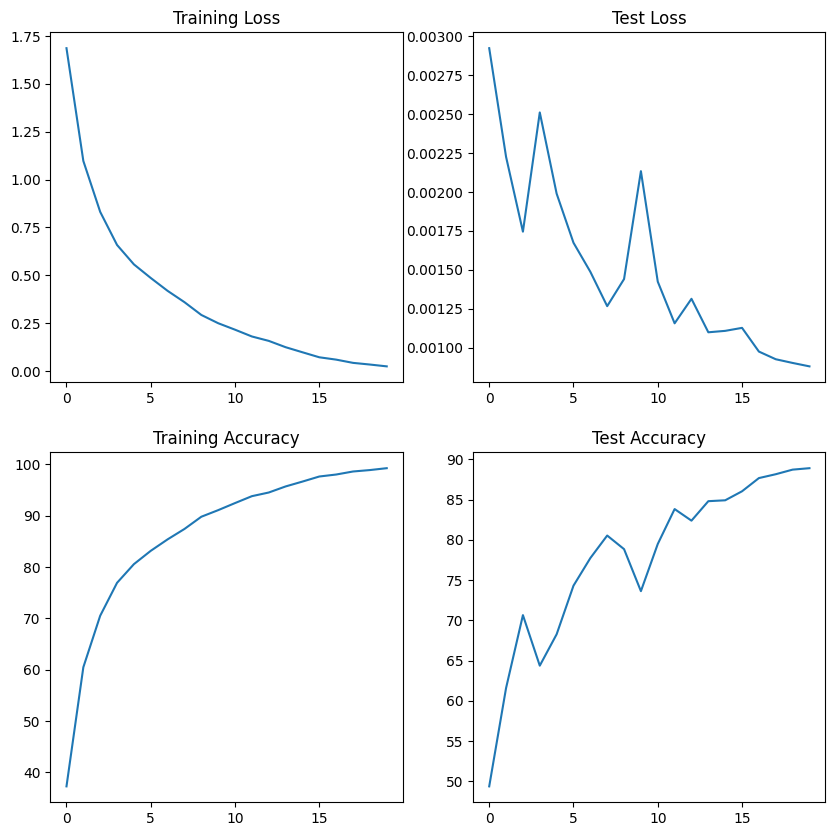

In [ ]:
# Print loss and accuracy
from visualize import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

Text(0.5, 1.0, 'Training Learning Rate')

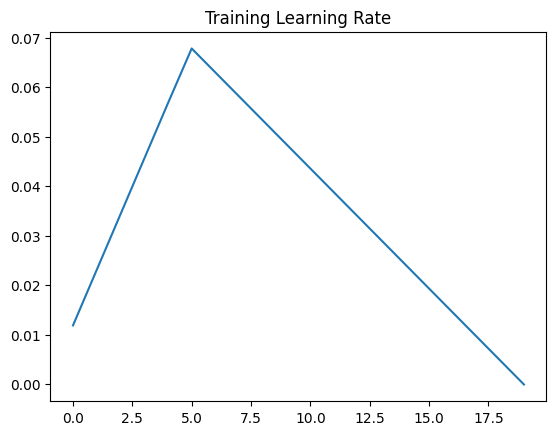

In [ ]:
import matplotlib.pyplot as plt

plt.plot(learning_rates)
plt.title("Training Learning Rate")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.save(model.state_dict(), "model.pth")
model.load_state_dict(torch.load("model.pth"), strict=False)

<All keys matched successfully>

In [ ]:
# Put the model on selected device
model = ResNet18().to(device)

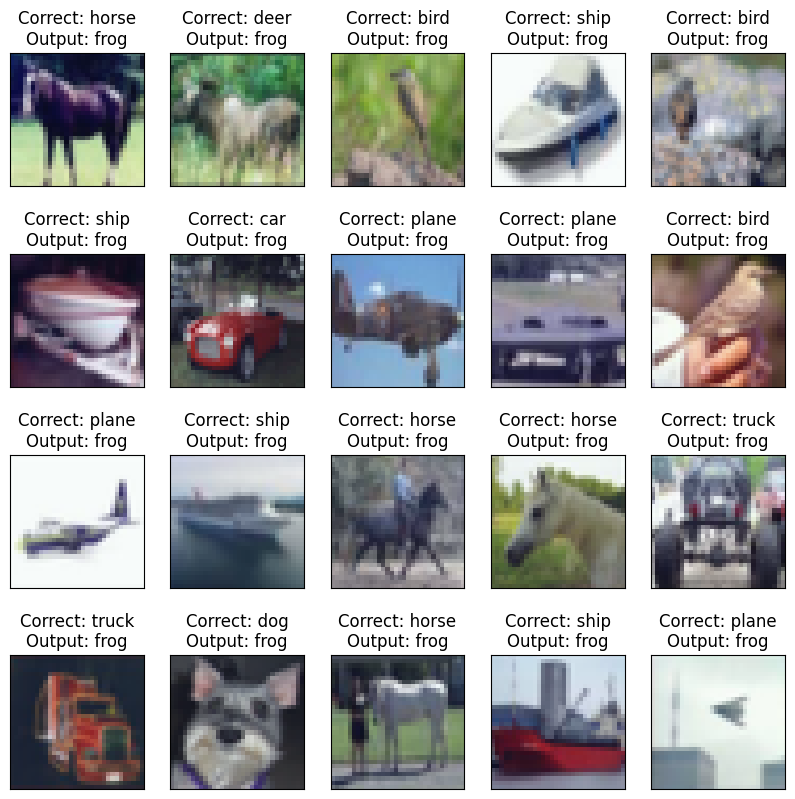

In [ ]:
from utils import get_misclassified_data
from visualize import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=20)

In [ ]:
from utils import display_gradcam_output

target_layers = [model.layer4[-1]]
# targets = [ClassifierOutputTarget(7)]
targets = None

display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.70)

Exception ignored in: <function BaseCAM.__del__ at 0x7f0c1a816710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


TypeError: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'

<Figure size 1000x1000 with 0 Axes>

In [ ]:
target_layers = [model.layer3[-2]]
display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.70)

Exception ignored in: <function BaseCAM.__del__ at 0x7f0c1a816710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


TypeError: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'

<Figure size 1000x1000 with 0 Axes>

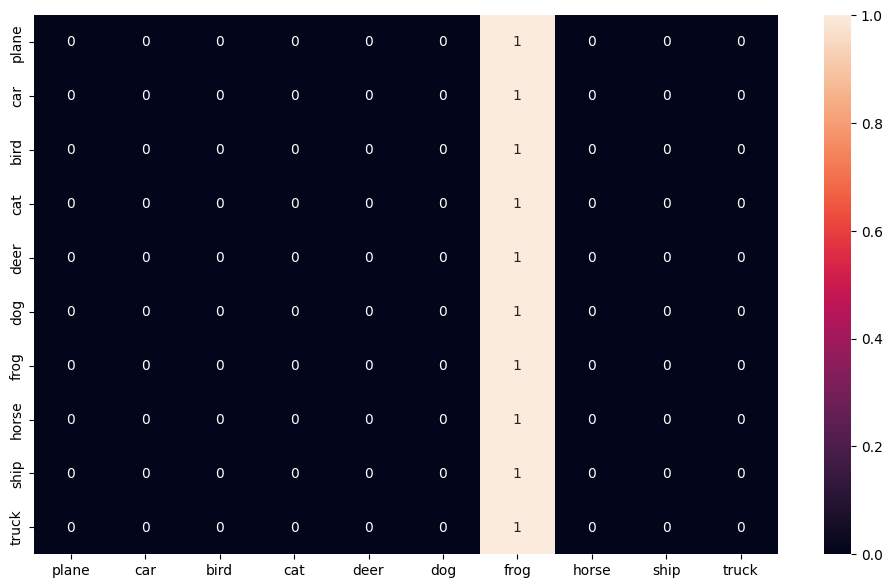

In [ ]:
from visualize import visualize_confusion_matrix

visualize_confusion_matrix(classes, device, model, test_loader)

In [ ]:
import gradio as gr

def hello(input1, input2, input3):
    return f'{input1} + {input2} Rohan'

demo = gr.Interface(hello, ["text", gr.Slider(0, 5, step=1), gr.Image(shape=(32, 32))], "text")
demo.launch()

i:\TSAI\2024\ERA V2\S13\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM

def inference(input_img, transparency):
    transform = transforms.ToTensor()
    input_img = transform(input_img)
    input_img = input_img.to(device)
    input_img = input_img.unsqueeze(0)
    outputs = model(input_img)
    _, prediction = torch.max(outputs, 1)
    target_layers = [model.layer2[-2]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_img, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    img = input_img.squeeze(0).to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img, (1, 2, 0))
    rgb_img = rgb_img.numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency)
    return classes[prediction[0].item()], visualization

demo = gr.Interface(inference, [gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])
demo.launch()

C:\Users\Rohan\AppData\Local\Temp\ipykernel_26288\2465537796.py:24: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  demo = gr.Interface(inference, [gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "i:\TSAI\2024\ERA V2\S13\.venv\lib\site-packages\gradio\routes.py", line 442, in run_predict
    output = await app.get_blocks().process_api(
  File "i:\TSAI\2024\ERA V2\S13\.venv\lib\site-packages\gradio\blocks.py", line 1392, in process_api
    result = await self.call_function(
  File "i:\TSAI\2024\ERA V2\S13\.venv\lib\site-packages\gradio\blocks.py", line 1097, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "i:\TSAI\2024\ERA V2\S13\.venv\lib\site-packages\anyio\to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "i:\TSAI\2024\ERA V2\S13\.venv\lib\site-packages\anyio\_backends\_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "i:\TSAI\2024\ERA V2\S13\.venv\lib\site-packages\anyio\_backends\_asyncio.py", line 807, in run
    result = context.run(func, *args)
  File "i:\TSAI\2024\ERA V2\S13\.venv\lib\site-packages\gradio\utils.py", lin

In [ ]:
import gradio as gr

In [ ]:
def hello(name, times):
  return f'Hello {name}\n'*times

text_demo = gr.Interface(
    fn = hello,
    inputs=['text', 'slider'],
    outputs=['text']
)

text_demo.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


# Components
Gradio includes more than 30 pre-built components (as well as many user-built custom components) that can be used as inputs or outputs in your demo with a single line of code. These components correspond to common data types in machine learning and data science, e.g. the gr.Image component is designed to handle input or output images, the gr.Label component displays classification labels and probabilities, the gr.Plot component displays various kinds of plots, and so on.

![img](https://github.com/gradio-app/gradio/blob/main/guides/assets/dataflow.svg?raw=true)

In [ ]:
# images
def image_classifier(img):
  return {'cat': 0.3, 'dog': 0.7}

img_demo = gr.Interface(
    fn=image_classifier,
    inputs="image",
    outputs="label"
)
img_demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


In [ ]:
# Chat
def echo(message, history):
  return message

demo = gr.ChatInterface(
    fn = echo,
    examples=["hello", "hola", "namaste"],
    title="Echo bot"
)
demo.launch()

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


In [ ]:
# Tabs

demo = gr.TabbedInterface(
    interface_list = [text_demo, img_demo],
    tab_names = ["Text Demo", "Image Demo"]
)

demo.launch()

i:\TSAI\2024\ERA V2\S13\.venv\lib\site-packages\gradio\blocks.py:942: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(


Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


In [ ]:
import gradio as gr
def update(name):
    return f"Welcome to Gradio, {name}!"

with gr.Blocks() as demo:
    gr.Markdown("Start typing below and then click **Run** to see the output.")
    with gr.Row():
        inp = gr.Textbox(placeholder="What is your name?")
        out = gr.Textbox()
    btn = gr.Button("Run")
    btn.click(fn=update, inputs=inp, outputs=out)

demo.launch()

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


In [ ]:
import numpy as np
import gradio as gr


def flip_text(x):
    return x[::-1]


def flip_image(x):
    return np.fliplr(x)


with gr.Blocks() as demo:
    gr.Markdown("Flip text or image files using this demo.")
    with gr.Tab("Flip Text"):
        text_input = gr.Textbox()
        text_output = gr.Textbox()
        text_button = gr.Button("Flip")
    with gr.Tab("Flip Image"):
        with gr.Row():
            image_input = gr.Image()
            image_output = gr.Image()
        image_button = gr.Button("Flip")

    with gr.Accordion("Open for More!", open=False):
        gr.Markdown("Look at me...")
        temp_slider = gr.Slider(
            minimum=0.0,
            maximum=1.0,
            value=0.1,
            step=0.1,
            interactive=True,
            label="Slide me",
        )
        temp_slider.change(lambda x: x, [temp_slider])

    text_button.click(flip_text, inputs=text_input, outputs=text_output)
    image_button.click(flip_image, inputs=image_input, outputs=image_output)

if __name__ == "__main__":
    demo.launch()


Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


In [ ]:
import pandas as pd
import numpy as np

import gradio as gr


def plot(v, a):
    g = 9.81
    theta = a / 180 * 3.14
    tmax = ((2 * v) * np.sin(theta)) / g
    timemat = tmax * np.linspace(0, 1, 40)

    x = (v * timemat) * np.cos(theta)
    y = ((v * timemat) * np.sin(theta)) - ((0.5 * g) * (timemat**2))
    df = pd.DataFrame({"x": x, "y": y})
    return df


demo = gr.Blocks()

with demo:
    gr.Markdown(
        r"Let's do some kinematics! Choose the speed and angle to see the trajectory. Remember that the range $R = v_0^2 \cdot \frac{\sin(2\theta)}{g}$"
    )

    with gr.Row():
        speed = gr.Slider(1, 30, 25, label="Speed")
        angle = gr.Slider(0, 90, 45, label="Angle")
    output = gr.LinePlot(
        x="x",
        y="y",
        overlay_point=True,
        tooltip=["x", "y"],
        x_lim=[0, 100],
        y_lim=[0, 60],
        width=350,
        height=300,
    )
    btn = gr.Button(value="Run")
    btn.click(plot, [speed, angle], output)

if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


In [ ]:
import gradio as gr
import numpy as np
import random

with gr.Blocks() as demo:
    section_labels = [
        "apple",
        "banana",
        "carrot",
        "donut",
        "eggplant",
        "fish",
        "grapes",
        "hamburger",
        "ice cream",
        "juice",
    ]

    with gr.Row():
        num_boxes = gr.Slider(0, 5, 2, step=1, label="Number of boxes")
        num_segments = gr.Slider(0, 5, 1, step=1, label="Number of segments")

    with gr.Row():
        img_input = gr.Image()
        img_output = gr.AnnotatedImage(
            color_map={"banana": "#a89a00", "carrot": "#ffae00"}
        )

    section_btn = gr.Button("Identify Sections")
    selected_section = gr.Textbox(label="Selected Section")

    def section(img, num_boxes, num_segments):
        sections = []
        for a in range(num_boxes):
            x = random.randint(0, img.shape[1])
            y = random.randint(0, img.shape[0])
            w = random.randint(0, img.shape[1] - x)
            h = random.randint(0, img.shape[0] - y)
            sections.append(((x, y, x + w, y + h), section_labels[a]))
        for b in range(num_segments):
            x = random.randint(0, img.shape[1])
            y = random.randint(0, img.shape[0])
            r = random.randint(0, min(x, y, img.shape[1] - x, img.shape[0] - y))
            mask = np.zeros(img.shape[:2])
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    dist_square = (i - y) ** 2 + (j - x) ** 2
                    if dist_square < r**2:
                        mask[i, j] = round((r**2 - dist_square) / r**2 * 4) / 4
            sections.append((mask, section_labels[b + num_boxes]))
        return (img, sections)

    section_btn.click(section, [img_input, num_boxes, num_segments], img_output)

    def select_section(evt: gr.SelectData):
        return section_labels[evt.index]

    img_output.select(select_section, None, selected_section)

if __name__ == "__main__":
    demo.launch()


Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


In [ ]:
import numpy as np
import gradio as gr

notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def generate_tone(note, octave, duration):
    sr = 48000
    a4_freq, tones_from_a4 = 440, 12 * (octave - 4) + (note - 9)
    frequency = a4_freq * 2 ** (tones_from_a4 / 12)
    duration = int(duration)
    audio = np.linspace(0, duration, duration * sr)
    audio = (20000 * np.sin(audio * (2 * np.pi * frequency))).astype(np.int16)
    return sr, audio

demo = gr.Interface(
    generate_tone,
    [
        gr.Dropdown(notes, type="index"),
        gr.Slider(4, 6, step=1),
        gr.Textbox(value=1, label="Duration in seconds"),
    ],
    "audio",
)
if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


In [ ]:
import gradio as gr
import numpy as np
import os
from PIL import Image, ImageColor


def change_color(icon, color):

    """
    Function that given an icon in .png format changes its color
    Args:
        icon: Icon whose color needs to be changed.
        color: Chosen color with which to edit the input icon.
    Returns:
        edited_image: Edited icon.
    """
    img = icon.convert("LA")
    img = img.convert("RGBA")
    image_np = np.array(icon)
    _, _, _, alpha = image_np.T
    mask = alpha > 0
    image_np[..., :-1][mask.T] = ImageColor.getcolor(color, "RGB")
    edited_image = Image.fromarray(image_np)
    return edited_image


inputs = [
    gr.Image(label="icon", type="pil", image_mode="RGBA"),
    gr.ColorPicker(label="color"),
]
outputs = gr.Image(label="colored icon")

demo = gr.Interface(
    fn=change_color,
    inputs=inputs,
    outputs=outputs
)

if __name__ == "__main__":
    demo.launch()



Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.
